[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14ZhsM3VKF8tRiVgtlsPYKDvfKrJKeipA)

# Machine Learning for Time Series Forecasting: Model Berbasis Pohon

**Tujuan Notebook:**

1.  Mempersiapkan data deret waktu menjadi format tabular untuk Machine Learning.
2.  Membangun fitur-fitur relevan dari data deret waktu (Feature Engineering).
3.  Mengimplementasikan dan melatih model Machine Learning berbasis pohon (Tree-Based Models).
4.  Melakukan peramalan menggunakan model ML.
5.  Mengevaluasi dan membandingkan kinerja model ML dengan model runtun waktu sebelumnya.


## Pendahuluan

Pada notebook sebelumnya, kita telah berhasil melatih model runtun waktu klasik (ARIMA, SARIMA) dan memodelkan volatilitas menggunakan ARCH/GARCH untuk peramalan harga Crude Oil WTI. Kita melihat bagaimana model gabungan ARIMA+GARCH dapat menghasilkan peramalan titik dan interval keyakinan yang dinamis, serta pentingnya penanganan non-normalitas dan heteroskedastisitas.

Meskipun kuat, model runtun waktu klasik seringkali mengandalkan asumsi stasioneritas atau linearitas dan mungkin kesulitan menangkap pola non-linear atau interaksi kompleks antara variabel. Machine Learning (ML) menawarkan pendekatan alternatif yang lebih fleksibel untuk peramalan deret waktu dengan memperlakukan masalah peramalan sebagai masalah regresi tabular.

Dalam notebook ini, kita akan beralih ke ranah Machine Learning, khususnya model berbasis pohon seperti Random Forest atau Gradient Boosting. Model-model ini dikenal karena kemampuannya menangani hubungan non-linear dan interaksi fitur secara otomatis. Kunci keberhasilan dalam pendekatan ini adalah proses **Feature Engineering**, di mana kita menciptakan fitur-fitur prediktif dari deret waktu itu sendiri dan sumber data eksternal (jika ada).

**Langkah Pertama:** Mempersiapkan data dan membangun fitur.

## 1. Persiapan Data dan Feature Engineering untuk Model ML

Model Machine Learning (khususnya model regresi seperti tree-based models) memerlukan data dalam format tabular (baris x kolom), di mana setiap baris mewakili sebuah observasi (periode waktu yang ingin diramalkan) dan setiap kolom adalah sebuah fitur atau variabel prediktif.

Deret waktu asli hanya memiliki satu kolom (harga) dan indeks waktu. Untuk mengubahnya menjadi format tabular, kita perlu menciptakan fitur-fitur baru. Beberapa jenis fitur yang umum digunakan dalam peramalan deret waktu berbasis ML meliputi:

*   **Lagged Values:** Nilai harga dari periode waktu sebelumnya. Ini adalah fitur paling penting karena deret waktu seringkali sangat berkorelasi dengan nilai masa lalunya. Lagged values menangkap dependensi temporal.
*   **Rolling Statistics:** Statistik pergerakan seperti rata-rata bergerak (moving average), deviasi standar bergerak (rolling standard deviation), minimum bergerak (rolling minimum), maksimum bergerak (rolling maximum) selama periode waktu tertentu. Ini membantu menangkap tren dan volatilitas lokal.
*   **Window Statistics:** Serupa dengan rolling statistics tetapi bisa mencakup rentang waktu yang tidak tumpang tindih.
*   **Date/Time Features:** Fitur yang diekstrak dari indeks tanggal/waktu, seperti tahun, bulan, hari dalam seminggu, hari dalam setahun, minggu dalam setahun, apakah hari libur, dll. Fitur ini membantu menangkap pola musiman atau kalender.
*   **External Regressors (Optional):** Variabel eksternal lain yang diyakini memengaruhi deret waktu target (misalnya, harga komoditas lain, nilai tukar mata uang, indikator ekonomi). Dalam notebook ini, kita akan fokus pada fitur yang berasal dari deret waktu itu sendiri karena kita tidak memiliki data eksternal tambahan.

Kita akan menggunakan data asli (harga Crude Oil WTI) sebagai dasar untuk feature engineering.

### Import Package dan Load Data


Data berhasil dimuat dan diproses awal:
            price   open   high    low     vol-k  change-%
date                                                      
2022-01-03  75.85  75.53  76.18  74.01  112230.0      1.30
2022-01-04  76.74  75.80  77.40  75.47  156450.0      1.17
2022-01-05  77.47  76.88  78.16  76.25  197970.0      0.95
2022-01-06  78.88  76.79  79.56  76.28  244000.0      1.82
2022-01-07  78.44  79.00  79.82  78.07  229280.0     -0.56

Jumlah data: 1002
Rentang tanggal: 2022-01-03 00:00:00 - 2024-09-30 00:00:00


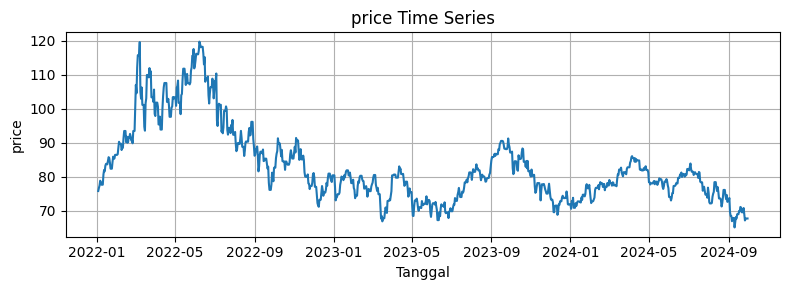

In [ ]:
# Import package yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Package untuk model Tree-Based
from xgboost import XGBRegressor

# Model Tree-Based sederhana dari scikit-learn sebagai permulaan
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Import fungsi untuk metrik evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error # MAPE akan dihitung manual atau pakai custom function

# Load Dataset
df = pd.read_csv('https://raw.githubusercontent.com/zakizulham/proyek-peramalan-global-comodity-price-september-2024/refs/heads/main/data/Arkavidiaa_Processed/Global_Commodity_Price/Crude_Oil_WTI.csv', parse_dates=['date'])

# Penyesuaian data sama seperti sebelumnya
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)
df = df.asfreq('D')
df = df.bfill()

# definisikan kolom target
target_column = 'price'

print("Data berhasil dimuat dan diproses awal:")
print(df.head())
print(f"\nJumlah data: {len(df)}")
print(f"Rentang tanggal: {df.index.min()} - {df.index.max()}")

# Visualisasi data
plt.figure(figsize=(8, 3))
plt.plot(df.index, df[target_column])
plt.title(f'{target_column} Time Series')
plt.xlabel('Tanggal')
plt.ylabel(target_column)
plt.grid(True)
plt.tight_layout()
plt.show()

### Membuat Fitur Lagged Values dan Rolling Statistics

Kita akan membuat beberapa fitur dasar:

*   Lagged values dari target (`price`) untuk beberapa periode waktu ke belakang.
*   Moving Average dari target selama beberapa periode waktu.

Pemilihan jumlah lag dan ukuran window untuk moving average adalah bagian dari proses *feature engineering* yang memerlukan eksperimen. Kita akan memulai dengan beberapa nilai yang umum.

In [ ]:
# Membuat dataset baru untuk fitur ML
df_ml = df.copy()

# --- Membuat Fitur Lagged Values ---
# Ini relatif aman jika Anda memprediksi t menggunakan t-lag
lags = [1, 7, 30, 365]
for lag in lags:
    df_ml[f'price_lag_{lag}'] = df_ml[target_column].shift(lag)

# --- Membuat Fitur Rolling Statistics ---
# **Ini perlu diperhatikan untuk menghindari leakage**
# Rolling window yang berakhir pada waktu t-1 untuk memprediksi waktu t
windows = [7, 30]
for window in windows:
    # Hitung rolling mean PADA DATA YANG SUDAH DIGESER 1 periode
    # Ini memastikan rolling mean dihitung menggunakan data hingga waktu t-1
    df_ml[f'price_rolling_mean_{window}'] = df_ml[target_column].shift(1).rolling(window=window).mean()
    # Atau, gunakan parameter closed='left' jika didukung oleh versi pandas Anda
    # df_ml[f'price_rolling_mean_{window}'] = df_ml[target_column].rolling(window=window, closed='left').mean()

    # Hitung rolling std PADA DATA YANG SUDAH DIGESER 1 periode
    df_ml[f'price_rolling_std_{window}'] = df_ml[target_column].shift(1).rolling(window=window).std()
    # Atau, gunakan closed='left'
    # df_ml[f'price_rolling_std_{window}'] = df_ml[target_column].rolling(window=window, closed='left').std()


# --- Membuat Fitur Date/Time --- (Ini aman karena hanya bergantung pada indeks waktu)
df_ml['year'] = df_ml.index.year
df_ml['month'] = df_ml.index.month
df_ml['day'] = df_ml.index.day
df_ml['dayofweek'] = df_ml.index.dayofweek
df_ml['dayofyear'] = df_ml.index.dayofyear
df_ml['weekofyear'] = df_ml.index.isocalendar().week.astype(int)
df_ml['is_weekend'] = (df_ml['dayofweek'] >= 5).astype(int)


# --- Menangani Missing Values Setelah Feature Engineering ---
# Ini tetap sama, Anda menghapus baris yang memiliki NaN
print(f"\nJumlah baris sebelum menghapus NaN: {len(df_ml)}")
df_ml.dropna(inplace=True)
print(f"Jumlah baris setelah menghapus NaN: {len(df_ml)}")


# --- Membagi Data Menjadi Data Latih dan Data Uji ---
# Pembagian ini tetap sama, berdasarkan tanggal kronologis
split_date = '2024-01-01'
data_latih_ml = df_ml.iloc[df_ml.index < split_date].copy()
data_uji_ml = df_ml.iloc[df_ml.index >= split_date].copy()

# Definisikan fitur (X) dan target (y)
features = [col for col in df_ml.columns if col != target_column]
target = target_column

X_latih = data_latih_ml[features]
y_latih = data_latih_ml[target]

X_uji = data_uji_ml[features]
y_uji = data_uji_ml[target]

print(f"\nData ML latih: {len(data_latih_ml)} baris (hingga {data_latih_ml.index[-1] if not data_latih_ml.empty else 'kosong'}).")
print(f"Data ML uji: {len(data_uji_ml)} baris (dari {data_uji_ml.index[0] if not data_uji_ml.empty else 'kosong'} hingga {data_uji_ml.index[-1] if not data_uji_ml.empty else 'kosong'}).")


Jumlah baris sebelum menghapus NaN: 1002
Jumlah baris setelah menghapus NaN: 637

Data ML latih: 363 baris (hingga 2023-12-31 00:00:00).
Data ML uji: 274 baris (dari 2024-01-01 00:00:00 hingga 2024-09-30 00:00:00).


### Membuat Fitur Date/Time

Menambahkan fitur yang diekstrak dari indeks tanggal dapat membantu model menangkap pola harian, mingguan, bulanan, atau tahunan.

In [ ]:
# Membuat fitur date/time
df_ml['year'] = df_ml.index.year
df_ml['month'] = df_ml.index.month
df_ml['day'] = df_ml.index.day
df_ml['dayofweek'] = df_ml.index.dayofweek # Senin=0, Minggu=6
df_ml['dayofyear'] = df_ml.index.dayofyear
df_ml['weekofyear'] = df_ml.index.isocalendar().week.astype(int) # Minggu dalam setahun
# df_ml['quarter'] = df_ml.index.quarter # Kuartal (optional)

# Fitur biner untuk akhir pekan (Sabtu atau Minggu)
df_ml['is_weekend'] = (df_ml['dayofweek'] >= 5).astype(int)

# Fitur biner untuk awal bulan/akhir bulan (optional)
# df_ml['is_month_start'] = df_ml.index.is_month_start.astype(int)
# df_ml['is_month_end'] = df_ml.index.is_month_end.astype(int)

print("\nDataFrame setelah menambahkan fitur date/time:")
print(df_ml.head())


DataFrame setelah menambahkan fitur date/time:
            price   open   high    low     vol-k  change-%  price_lag_1  \
date                                                                      
2023-01-03  77.12  80.66  81.62  76.81  139840.0     -4.16        80.47   
2023-01-04  73.10  77.41  77.62  73.01  149770.0     -5.21        77.12   
2023-01-05  73.92  73.51  75.15  72.74  112450.0      1.12        73.10   
2023-01-06  74.04  74.18  75.71  73.52   95220.0      0.16        73.92   
2023-01-07  74.92  73.87  76.97  73.79  154200.0      1.19        74.04   

            price_lag_7  price_lag_30  price_lag_365  ...  \
date                                                  ...   
2023-01-03        79.64         77.08          75.85  ...   
2023-01-04        79.08         77.08          76.74  ...   
2023-01-05        78.50         74.46          77.47  ...   
2023-01-06        80.45         72.28          78.88  ...   
2023-01-07        80.47         71.58          78.44  ...   

### Menangani Missing Values Setelah Feature Engineering

Proses pembuatan fitur seperti lagged values dan rolling statistics akan menghasilkan *missing values* (`NaN`) di awal deret waktu. Model ML tidak bisa menangani `NaN` secara langsung, jadi kita perlu mengatasinya. Opsi umum meliputi:

*   Menghapus baris yang mengandung `NaN` (paling sederhana, tetapi mengurangi jumlah data latih).
*   Mengisi `NaN` dengan nilai tertentu (misalnya, nilai sebelumnya, rata-rata, median, interpolasi). Ini memerlukan kehati-hatian agar tidak menyebabkan data bocor dari masa depan.

Untuk kesederhanaan dalam notebook ini, kita akan menghapus baris yang mengandung `NaN`. Jumlah `NaN` akan ditentukan oleh lag atau window rolling terbesar yang digunakan (dalam kasus ini, lag 365).

In [ ]:
# Menangani missing values (NaN) yang muncul akibat feature engineering
print(f"\nJumlah baris sebelum menghapus NaN: {len(df_ml)}")
df_ml.dropna(inplace=True)
print(f"Jumlah baris setelah menghapus NaN: {len(df_ml)}")

print("\nDataFrame setelah menghapus baris dengan NaN:")
print(df_ml.head())
print(f"Rentang tanggal setelah menghapus NaN: {df_ml.index.min()} - {df_ml.index.max()}")


Jumlah baris sebelum menghapus NaN: 637
Jumlah baris setelah menghapus NaN: 637

DataFrame setelah menghapus baris dengan NaN:
            price   open   high    low     vol-k  change-%  price_lag_1  \
date                                                                      
2023-01-03  77.12  80.66  81.62  76.81  139840.0     -4.16        80.47   
2023-01-04  73.10  77.41  77.62  73.01  149770.0     -5.21        77.12   
2023-01-05  73.92  73.51  75.15  72.74  112450.0      1.12        73.10   
2023-01-06  74.04  74.18  75.71  73.52   95220.0      0.16        73.92   
2023-01-07  74.92  73.87  76.97  73.79  154200.0      1.19        74.04   

            price_lag_7  price_lag_30  price_lag_365  ...  \
date                                                  ...   
2023-01-03        79.64         77.08          75.85  ...   
2023-01-04        79.08         77.08          76.74  ...   
2023-01-05        78.50         74.46          77.47  ...   
2023-01-06        80.45         72.28    

### Membagi Data Menjadi Data Latih dan Data Uji

Mirip dengan model runtun waktu, kita perlu membagi data menjadi set pelatihan dan pengujian. Namun, pembagian ini harus dilakukan secara kronologis untuk menghindari *data leakage* dari masa depan ke masa lalu. Kita akan menggunakan metode *fixed split* berdasarkan tanggal yang sama seperti sebelumnya (`2024-01-01`).

Target untuk model ML adalah kolom `price` itu sendiri pada waktu `t`, dan fitur-fiturnya adalah nilai-nilai dari waktu `t-lag` atau statistik pada waktu `t`.

In [ ]:
# Tentukan tanggal split
split_date = '2024-01-01'

# Membagi data berdasarkan tanggal
data_latih_ml = df_ml.iloc[df_ml.index < split_date].copy()
data_uji_ml = df_ml.iloc[df_ml.index >= split_date].copy()

print(f"\nData ML latih: {len(data_latih_ml)} baris (hingga {data_latih_ml.index[-1] if not data_latih_ml.empty else 'kosong'}).")
print(f"Data ML uji: {len(data_uji_ml)} baris (dari {data_uji_ml.index[0] if not data_uji_ml.empty else 'kosong'} hingga {data_uji_ml.index[-1] if not data_uji_ml.empty else 'kosong'}).")

# Definisikan fitur (X) dan target (y)
features = [col for col in df_ml.columns if col != target_column]
target = target_column

X_latih = data_latih_ml[features]
y_latih = data_latih_ml[target]

X_uji = data_uji_ml[features]
y_uji = data_uji_ml[target]

print(f"\nFitur yang digunakan ({len(features)}): {features}")
print("\nShape data latih:")
print("X_latih:", X_latih.shape)
print("y_latih:", y_latih.shape)
print("\nShape data uji:")
print("X_uji:", X_uji.shape)
print("y_uji:", y_uji.shape)


Data ML latih: 363 baris (hingga 2023-12-31 00:00:00).
Data ML uji: 274 baris (dari 2024-01-01 00:00:00 hingga 2024-09-30 00:00:00).

Fitur yang digunakan (20): ['open', 'high', 'low', 'vol-k', 'change-%', 'price_lag_1', 'price_lag_7', 'price_lag_30', 'price_lag_365', 'price_rolling_mean_7', 'price_rolling_std_7', 'price_rolling_mean_30', 'price_rolling_std_30', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'is_weekend']

Shape data latih:
X_latih: (363, 20)
y_latih: (363,)

Shape data uji:
X_uji: (274, 20)
y_uji: (274,)


Data sekarang sudah dalam format tabular yang siap digunakan untuk melatih model Machine Learning. Kolom `X_latih` dan `X_uji` berisi fitur-fitur prediktif, dan `y_latih` serta `y_uji` berisi nilai target yang ingin diramalkan.


## Pemodelan Machine Learning untuk Peramalan

Setelah data disiapkan dan diubah ke format tabular dengan fitur-fitur *lag* dan target, kita dapat melanjutkan ke tahap pemodelan Machine Learning. Berbagai algoritma ML dapat digunakan untuk peramalan deret waktu dalam format tabular ini. Dalam bagian ini, kita akan fokus pada model berbasis pohon, seperti Gradient Boosting Machines (misalnya, XGBoost atau LightGBM) atau Random Forest, yang seringkali memberikan kinerja baik pada data tabular dan mampu menangkap interaksi non-linear antar fitur.

Langkah-langkah yang akan kita lakukan meliputi:

1.  **Memilih Model ML:** Memilih algoritma model berbasis pohon.
2.  **Melatih Model:** Melatih model yang dipilih menggunakan data latih (`X_latih`, `y_latih`).
3.  **Melakukan Peramalan:** Menggunakan model yang sudah dilatih untuk melakukan peramalan pada data uji (`X_uji`).
4.  **Mengevaluasi Peramalan:** Mengevaluasi kinerja model pada data uji menggunakan metrik peramalan standar.
5.  **Visualisasi Hasil:** Memvisualisasikan hasil peramalan dibandingkan dengan nilai aktual pada data uji.

Kita akan menggunakan pustaka `scikit-learn` atau pustaka spesifik model seperti `xgboost` atau `lightgbm`. Untuk demonstrasi, kita akan menggunakan **Random Forest Regressor** dari `scikit-learn` sebagai titik awal karena kemudahannya dalam implementasi dan interpretasi awal.

### 1. Memilih dan Mengimpor Model ML

Kita akan mengimpor `RandomForestRegressor` dari `sklearn.ensemble`.

In [ ]:
# Import model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np # Diimpor sebelumnya, tapi pastikan ada
import pandas as pd # Diimpor sebelumnya, tapi pastikan ada

# Import MinMaxScaler jika ingin menormalkan data sebelum melatih model ML (opsional)
# from sklearn.preprocessing import MinMaxScaler

### 2. Melatih Model Random Forest Regressor

Model Random Forest akan dilatih menggunakan pasangan fitur (`X_latih`) dan nilai target (`y_latih`) yang telah kita siapkan sebelumnya. Kita akan menggunakan parameter default untuk permulaan, tetapi parameter ini bisa disetel (tuning) lebih lanjut untuk meningkatkan kinerja.

In [ ]:
# Inisialisasi model Random Forest Regressor
# n_estimators: jumlah pohon dalam forest
# random_state: untuk hasil yang reproducible
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Latih model menggunakan data latih
print("Melatih model Random Forest...")
model_rf.fit(X_latih, y_latih)
print("Pelatihan model Random Forest selesai.")

Melatih model Random Forest...
Pelatihan model Random Forest selesai.


### 3. Melakukan Peramalan pada Data Uji

Setelah model dilatih, kita akan menggunakan model tersebut untuk memprediksi nilai target pada data uji (`X_uji`).

In [ ]:
# Lakukan peramalan pada data uji
print("Melakukan peramalan pada data uji...")
peramalan_rf = model_rf.predict(X_uji)
print("Peramalan selesai.")

# Output hasil peramalan (beberapa nilai pertama)
print("\nHasil peramalan Random Forest pada data uji (beberapa nilai pertama):")
print(peramalan_rf[:10])

Melakukan peramalan pada data uji...
Peramalan selesai.

Hasil peramalan Random Forest pada data uji (beberapa nilai pertama):
[71.8203 71.5658 72.6172 71.9675 73.7837 71.4927 71.4369 71.4775 72.66
 71.8835]


### 4. Mengevaluasi Peramalan Model Random Forest

Kita akan mengevaluasi kinerja model Random Forest pada data uji menggunakan metrik yang sama seperti pada model ARIMA, yaitu:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Percentage Error (MAPE)

Kita akan membandingkan nilai peramalan (`peramalan_rf`) dengan nilai aktual pada data uji (`y_uji`). Pastikan bahwa panjang kedua array (peramalan dan aktual) sama.

In [ ]:
# Pastikan y_uji adalah array numpy atau Series pandas agar operasi metrik lancar
y_uji_values = y_uji.values if isinstance(y_uji, (pd.Series, pd.DataFrame)) else y_uji

# Hitung metrik evaluasi
mae_rf = mean_absolute_error(y_uji_values, peramalan_rf)
mse_rf = mean_squared_error(y_uji_values, peramalan_rf)
rmse_rf = np.sqrt(mse_rf)
# Hitung MAPE secara manual atau gunakan implementasi yang menghindari pembagian dengan nol
# MAPE dapat sensitif jika nilai aktual y_uji mendekati nol.
# Implementasi sederhana MAPE:
mape_rf = np.mean(np.abs((y_uji_values - peramalan_rf) / y_uji_values)) * 100

print("\nMetrik Evaluasi Model Random Forest pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.4f}%")


Metrik Evaluasi Model Random Forest pada Data Uji:
Mean Absolute Error (MAE): 0.4580
Mean Squared Error (MSE): 0.3565
Root Mean Squared Error (RMSE): 0.5971
Mean Absolute Percentage Error (MAPE): 0.6057%


### 5. Visualisasi Hasil Peramalan

Memvisualisasikan nilai aktual dan peramalan pada data uji sangat penting untuk memahami seberapa baik model menangkap pola deret waktu.

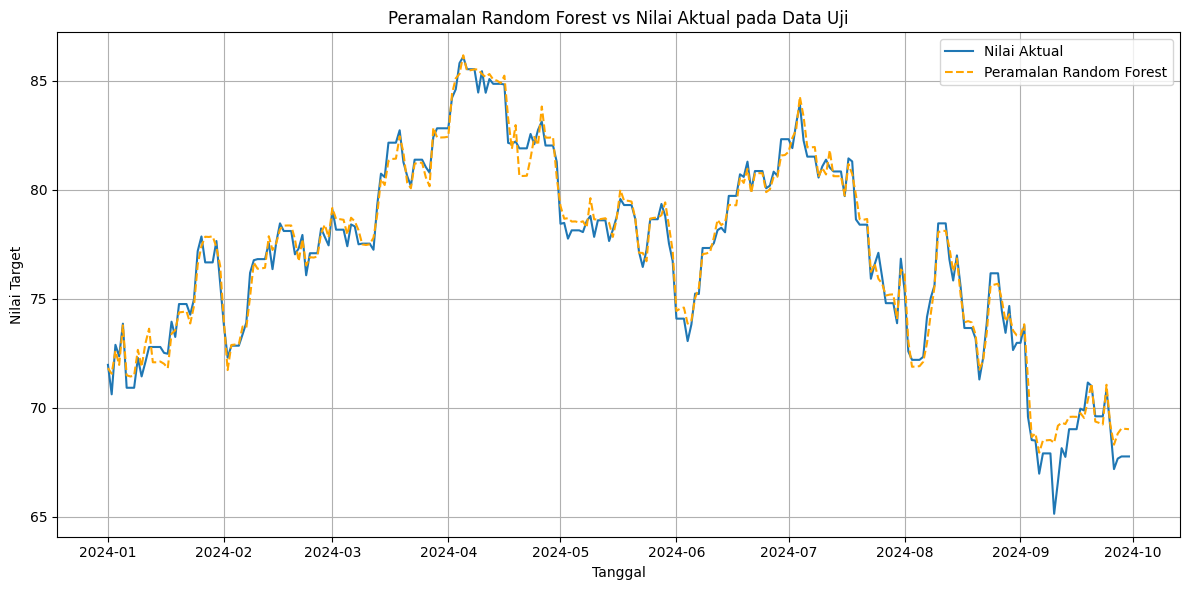

In [ ]:
import matplotlib.pyplot as plt # Diimpor sebelumnya, tapi pastikan ada

# Buat DataFrame untuk visualisasi agar mudah plotting berdasarkan indeks waktu
hasil_peramalan_rf_df = pd.DataFrame({
    'Aktual': y_uji_values,
    'Peramalan_RF': peramalan_rf
}, index=X_uji.index) # Gunakan indeks dari X_uji untuk tanggal

# Visualisasikan hasil peramalan vs nilai aktual pada data uji
plt.figure(figsize=(12, 6))
plt.plot(hasil_peramalan_rf_df.index, hasil_peramalan_rf_df['Aktual'], label='Nilai Aktual')
plt.plot(hasil_peramalan_rf_df.index, hasil_peramalan_rf_df['Peramalan_RF'], label='Peramalan Random Forest', color='orange', linestyle='--')
plt.title('Peramalan Random Forest vs Nilai Aktual pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Target') # Ganti dengan nama kolom target yang relevan
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Ringkasan Hasil Pemodelan ML

Berdasarkan metrik evaluasi dan visualisasi, kita dapat menilai seberapa baik model Random Forest menangkap pola deret waktu pada data uji. Bandingkan metrik ini dengan hasil model ARIMA sebelumnya untuk melihat apakah pendekatan berbasis ML memberikan peningkatan kinerja peramalan.

**Langkah Selanjutnya (Opsional):**

-   **Hyperparameter Tuning:** Coba atur parameter model Random Forest (`n_estimators`, `max_depth`, `min_samples_split`, dll.) menggunakan teknik seperti Grid Search atau Random Search untuk menemukan kombinasi terbaik yang meminimalkan error pada data uji atau menggunakan cross-validation.
-   **Model ML Lain:** Eksplorasi algoritma ML berbasis pohon lainnya seperti XGBoost, LightGBM, atau CatBoost, yang seringkali memberikan kinerja lebih tinggi.
-   **Validasi Silang (Cross-Validation):** Gunakan teknik validasi silang khusus deret waktu (seperti TimeSeriesSplit) untuk mendapatkan estimasi kinerja model yang lebih robust.
-   **Peramalan Multistep:** Sesuaikan proses peramalan jika Anda perlu memprediksi lebih dari satu langkah ke depan secara rekursif.

### Mengeksplorasi XGBoost untuk Peramalan

XGBoost (Extreme Gradient Boosting) adalah implementasi dari algoritma gradient boosting yang dioptimalkan dan sangat populer karena kecepatannya dan kinerjanya yang tinggi dalam berbagai tugas Machine Learning, termasuk peramalan deret waktu. Dibandingkan dengan Random Forest yang membangun pohon secara independen, Gradient Boosting membangun pohon secara sekuensial, di mana setiap pohon baru mencoba memperbaiki kesalahan yang dibuat oleh pohon sebelumnya.

Dalam bagian ini, kita akan mengganti Random Forest dengan XGBoost untuk melihat apakah ini memberikan peningkatan kinerja peramalan.

Langkah-langkahnya mirip dengan sebelumnya:

1.  **Mengimpor Model XGBoost.**
2.  **Melatih Model XGBoost:** Melatih model menggunakan data latih (`X_latih`, `y_latih`). Kita akan menggunakan fungsionalitas *early stopping* untuk menghindari *overfitting*.
3.  **Melakukan Peramalan:** Menggunakan model yang sudah dilatih untuk melakukan peramalan pada data uji (`X_uji`).
4.  **Mengevaluasi Peramalan:** Mengevaluasi kinerja model pada data uji.
5.  **Visualisasi Hasil:** Memvisualisasikan hasil peramalan dibandingkan dengan nilai aktual.

In [ ]:
# Import XGBoost Regressor
import xgboost as xgb

# Import metrik evaluasi (sudah diimpor sebelumnya, tapi pastikan ada)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan data latih dan uji (X_latih, y_latih, X_uji, y_uji) sudah disiapkan dari langkah sebelumnya
# Jika belum, jalankan kembali bagian persiapan data

# Untuk menggunakan early stopping, XGBoost memerlukan data evaluasi dalam format DMatrix
# Jika Anda menggunakan API scikit-learn (xgb.XGBRegressor), Anda bisa menggunakan argumen eval_set

### 2. Melatih Model XGBoost

Kita akan melatih `xgb.XGBRegressor` pada data latih. Untuk memanfaatkan *early stopping*, kita perlu menyediakan *evaluation set* (`eval_set`) selama pelatihan. Kita bisa menggunakan sebagian data latih atau data uji sebagai *evaluation set*. Menggunakan data uji sebagai *eval_set* selama pelatihan adalah cara yang umum, meskipun perlu diingat bahwa ini "membocorkan" informasi dari data uji ke dalam proses pelatihan (hanya untuk tujuan monitoring dan *early stopping*, bukan untuk mengoptimalkan parameter secara langsung terhadap data uji). Atau, kita bisa membagi data latih menjadi latih dan validasi. Untuk kesederhanaan di sini, kita akan menggunakan data uji sebagai `eval_set` seperti contoh umum, namun dalam proyek nyata membagi data latih untuk validasi seringkali lebih disarankan.

Kita juga akan menggunakan `early_stopping_rounds` untuk menghentikan pelatihan jika kinerja pada `eval_set` tidak membaik setelah sejumlah putaran (epochs).

In [ ]:
from xgboost.callback import EarlyStopping

In [ ]:
# Definisikan early stopping callback
# Hanya perlu menentukan rounds (jumlah putaran tanpa peningkatan kinerja sebelum berhenti)
early_stopping_callback = EarlyStopping(rounds=50)

In [ ]:
# Inisialisasi model XGBoost Regressor
# n_estimators: jumlah boosting rounds (pohon) - bisa diatur lebih tinggi dengan early stopping
# learning_rate: seberapa besar setiap pohon berkontribusi
# objective: fungsi kerugian (reg:squarederror untuk regresi)
model_xgb = xgb.XGBRegressor(n_estimators=500, # Turunkan jumlah estimator jika tanpa early stopping
                             learning_rate=0.05,
                             early_stopping_rounds = 50,
                             objective='reg:squarederror',
                             random_state=42,
                             n_jobs=-1)

# Definisikan evaluation set
# XGBoost menggunakan (fitur, target)
eval_set = [(X_latih, y_latih), (X_uji, y_uji)]

# Latih model menggunakan data latih dan evaluation set
print("Melatih model XGBoost dengan early stopping...")
model_xgb.fit(X_latih, y_latih,
              eval_set=eval_set,
                # Berhenti jika tidak ada peningkatan setelah 10 iterasi
              verbose=False) # Atur ke True jika ingin melihat progress pelatihan [1]
print("Pelatihan model XGBoost selesai.")

# Jumlah estimator terbaik setelah early stopping
print(f"Jumlah estimator terbaik setelah early stopping: {model_xgb.best_iteration}")

Melatih model XGBoost dengan early stopping...
Pelatihan model XGBoost selesai.
Jumlah estimator terbaik setelah early stopping: 187


### 3. Melakukan Peramalan pada Data Uji

Setelah model dilatih (dan dihentikan lebih awal jika *early stopping* aktif), kita akan menggunakan model tersebut untuk memprediksi nilai target pada data uji (`X_uji`).

In [ ]:
# Lakukan peramalan pada data uji menggunakan model XGBoost
print("Melakukan peramalan pada data uji menggunakan XGBoost...")
peramalan_xgb = model_xgb.predict(X_uji)
print("Peramalan selesai.")

# Output hasil peramalan (beberapa nilai pertama)
print("\nHasil peramalan XGBoost pada data uji (beberapa nilai pertama):")
print(peramalan_xgb[:10])

Melakukan peramalan pada data uji menggunakan XGBoost...
Peramalan selesai.

Hasil peramalan XGBoost pada data uji (beberapa nilai pertama):
[71.85266  71.01126  72.65647  72.058815 74.32425  70.99679  70.93208
 70.92353  72.61691  71.898125]


### 4. Mengevaluasi Peramalan Model XGBoost

Hitung metrik evaluasi (MAE, MSE, RMSE, MAPE) untuk peramalan XGBoost dan bandingkan dengan nilai aktual pada data uji (`y_uji`).

In [ ]:
# Pastikan y_uji adalah array numpy atau Series pandas
y_uji_values = y_uji.values if isinstance(y_uji, (pd.Series, pd.DataFrame)) else y_uji

# Hitung metrik evaluasi untuk XGBoost
mae_xgb = mean_absolute_error(y_uji_values, peramalan_xgb)
mse_xgb = mean_squared_error(y_uji_values, peramalan_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Hitung MAPE untuk XGBoost
mape_xgb = np.mean(np.abs((y_uji_values - peramalan_xgb) / y_uji_values)) * 100

print("\nMetrik Evaluasi Model XGBoost pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.4f}%")


Metrik Evaluasi Model XGBoost pada Data Uji:
Mean Absolute Error (MAE): 0.4179
Mean Squared Error (MSE): 0.3499
Root Mean Squared Error (RMSE): 0.5916
Mean Absolute Percentage Error (MAPE): 0.5592%


### 5. Visualisasi Hasil Peramalan

Visualisasikan nilai aktual dan peramalan dari model XGBoost pada data uji.

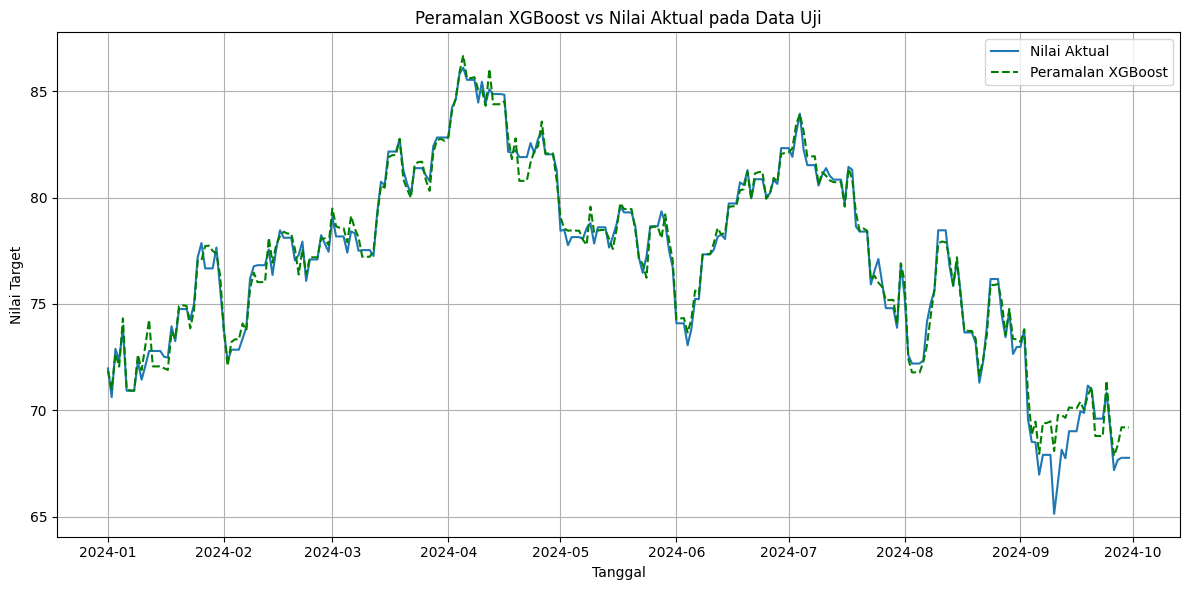

In [ ]:
# Buat DataFrame untuk visualisasi hasil XGBoost
hasil_peramalan_xgb_df = pd.DataFrame({
    'Aktual': y_uji_values,
    'Peramalan_XGB': peramalan_xgb
}, index=X_uji.index) # Gunakan indeks dari X_uji untuk tanggal

# Visualisasikan hasil peramalan XGBoost vs nilai aktual
plt.figure(figsize=(12, 6))
plt.plot(hasil_peramalan_xgb_df.index, hasil_peramalan_xgb_df['Aktual'], label='Nilai Aktual')
plt.plot(hasil_peramalan_xgb_df.index, hasil_peramalan_xgb_df['Peramalan_XGB'], label='Peramalan XGBoost', color='green', linestyle='--')
plt.title('Peramalan XGBoost vs Nilai Aktual pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Perbandingan Kinerja Model

Bandingkan metrik evaluasi dari model Random Forest dan XGBoost (serta ARIMA dari notebook sebelumnya jika ada) untuk menentukan model mana yang memberikan kinerja peramalan terbaik pada data uji. XGBoost seringkali lebih baik, terutama dengan dataset yang lebih besar dan kompleksitas non-linear yang tinggi.

**Langkah Selanjutnya (untuk penyempurnaan model ML):**

-   **Hyperparameter Tuning XGBoost:** Tuning parameter XGBoost (misalnya, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`) dapat lebih lanjut meningkatkan kinerja.
-   **Feature Engineering Lanjutan:** Tambahkan fitur lain yang mungkin relevan, seperti indikator teknis, fitur berbasis kalender (hari dalam seminggu, bulan, dll.), atau informasi dari deret waktu terkait lainnya.
-   **Validasi Silang:** Gunakan `TimeSeriesSplit` untuk evaluasi model yang lebih ketat dan robust.

## Penyempurnaan Model XGBoost: Hyperparameter Tuning

Setelah melatih model XGBoost dengan parameter default atau awal, langkah selanjutnya untuk meningkatkan kinerjanya adalah dengan melakukan **Hyperparameter Tuning**. Hyperparameter adalah parameter model yang tidak dipelajari dari data, melainkan diatur sebelum proses pelatihan dimulai (contoh: `learning_rate`, `max_depth`, `n_estimators`, dll.). Menemukan kombinasi hyperparameter yang optimal dapat secara signifikan meningkatkan kemampuan generalisasi model pada data yang tidak terlihat.

Teknik umum untuk hyperparameter tuning meliputi:

1.  **Grid Search:** Mencoba semua kombinasi parameter dalam grid yang ditentukan.
2.  **Random Search:** Mencoba kombinasi parameter acak dalam rentang yang ditentukan.
3.  **Teknik yang Lebih Lanjut:** Bayesian Optimization, Tree-structured Parzen Estimator (TPE), dll.

Untuk demonstrasi, kita akan menggunakan **Random Search** karena lebih efisien daripada Grid Search pada ruang parameter yang besar dan seringkali memberikan hasil yang mendekati optimal dalam waktu yang lebih singkat. Kita akan menggunakan `RandomizedSearchCV` dari `sklearn.model_selection`.

Karena kita bekerja dengan data deret waktu, penting untuk menggunakan teknik validasi silang (cross-validation) yang tepat. `RandomizedSearchCV` memungkinkan kita untuk menentukan strategi validasi silang menggunakan argumen `cv`. Untuk deret waktu, kita harus menggunakan `TimeSeriesSplit` untuk memastikan bahwa data validasi selalu datang setelah data latih dalam setiap *fold*.

Langkah-langkahnya adalah sebagai berikut:

1.  **Menentukan Ruang Parameter:** Menentukan rentang atau daftar nilai untuk setiap hyperparameter yang ingin kita *tune*.
2.  **Mengatur Validasi Silang untuk Deret Waktu:** Menggunakan `TimeSeriesSplit`.
3.  **Melakukan Random Search:** Menjalankan `RandomizedSearchCV` untuk mencari kombinasi parameter terbaik.
4.  **Mengevaluasi Model Terbaik:** Melatih model XGBoost dengan parameter terbaik yang ditemukan dan mengevaluasinya pada data uji.

In [ ]:
# Import pustaka yang diperlukan
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd

# Pastikan data latih dan uji (X_latih, y_latih, X_uji, y_uji) sudah disiapkan
# Serta data gabungan latih+uji jika diperlukan untuk validasi silang (TSS)
# TimeSeriesSplit akan bekerja langsung pada X_latih dan y_latih

# Untuk RandomizedSearchCV, kita perlu mendefinisikan ruang parameter yang akan dicari
# Ini adalah kamus di mana kunci adalah nama parameter dan nilai adalah distribusi atau daftar nilai
param_dist = {
    'n_estimators': [100, 200, 500, 1000, 1500], # Jumlah boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Tingkat pembelajaran
    'max_depth': [3, 4, 5, 6, 7, 8],            # Kedalaman maksimum pohon
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Proporsi sampel pelatihan per pohon
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Proporsi fitur per pohon
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],           # Minimum loss reduction untuk membuat partisi
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],      # Regularisasi L1
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1]       # Regularisasi L2
}

# Definisikan metrik yang akan digunakan untuk evaluasi tuning
# Kita akan menggunakan Negated Mean Squared Error (neg_mse) karena RandomizedSearchCV mencari skor maksimum
# Jadi, memaksimalkan -MSE sama dengan meminimalkan MSE
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Konfigurasi TimeSeriesSplit
# n_splits: jumlah lipatan (folds)
# gap: jumlah sampel yang harus dilewati antara data pelatihan dan pengujian dalam setiap lipatan
n_splits = 5 # Sesuaikan jumlah lipatan sesuai kebutuhan dan ukuran data
tss = TimeSeriesSplit(n_splits=n_splits)

# Inisialisasi model dasar XGBoost (parameter awal, akan di-tune)
xgb_base = xgb.XGBRegressor(objective='reg:squarederror',
                            random_state=42,
                            n_jobs=-1)

# Inisialisasi RandomizedSearchCV
# estimator: model dasar yang akan di-tune
# param_distributions: ruang parameter yang akan dicari
# n_iter: jumlah kombinasi parameter yang akan dicoba (semakin besar, semakin lama tapi hasil bisa lebih baik)
# scoring: metrik evaluasi
# cv: strategi validasi silang
# verbose: level detail output saat proses tuning berjalan
random_search = RandomizedSearchCV(estimator=xgb_base,
                                   param_distributions=param_dist,
                                   n_iter=50, # Jumlah kombinasi acak yang dicoba
                                   scoring=neg_mse_scorer,
                                   cv=tss,
                                   verbose=2, # Atur ke 1 atau 2 untuk melihat progress
                                   random_state=42,
                                   n_jobs=-1) # Gunakan semua core CPU untuk mempercepat

# Lakukan proses tuning
print("Memulai Hyperparameter Tuning dengan Randomized Search dan TimeSeriesSplit...")
# Fit RandomizedSearchCV hanya pada data Latih
random_search.fit(X_latih, y_latih)
print("Proses Hyperparameter Tuning selesai.")

# Tampilkan parameter terbaik yang ditemukan
print("\nParameter terbaik yang ditemukan oleh Randomized Search:")
print(random_search.best_params_)

# Tampilkan skor terbaik (Negated MSE)
print(f"\nSkor validasi silang terbaik (Negated MSE): {random_search.best_score_:.4f}")
print(f"Ini setara dengan RMSE: {np.sqrt(-random_search.best_score_):.4f}")

Memulai Hyperparameter Tuning dengan Randomized Search dan TimeSeriesSplit...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Proses Hyperparameter Tuning selesai.

Parameter terbaik yang ditemukan oleh Randomized Search:
{'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.001, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

Skor validasi silang terbaik (Negated MSE): -3.2036
Ini setara dengan RMSE: 1.7899



Memeriksa beberapa nilai data uji vs peramalan:
Tanggal | Aktual | Peramalan XGB | Selisih
------- | ------ | ------------- | -------
2024-01-01 | 71.9700 | 71.8527 | 0.1173
2024-01-02 | 70.6200 | 71.0113 | -0.3913
2024-01-03 | 72.8900 | 72.6565 | 0.2335
2024-01-04 | 72.3600 | 72.0588 | 0.3012
2024-01-05 | 73.8600 | 74.3242 | -0.4642
2024-01-06 | 70.9200 | 70.9968 | -0.0768
2024-01-07 | 70.9200 | 70.9321 | -0.0121
2024-01-08 | 70.9200 | 70.9235 | -0.0035
2024-01-09 | 72.2900 | 72.6169 | -0.3269
2024-01-10 | 71.4400 | 71.8981 | -0.4581


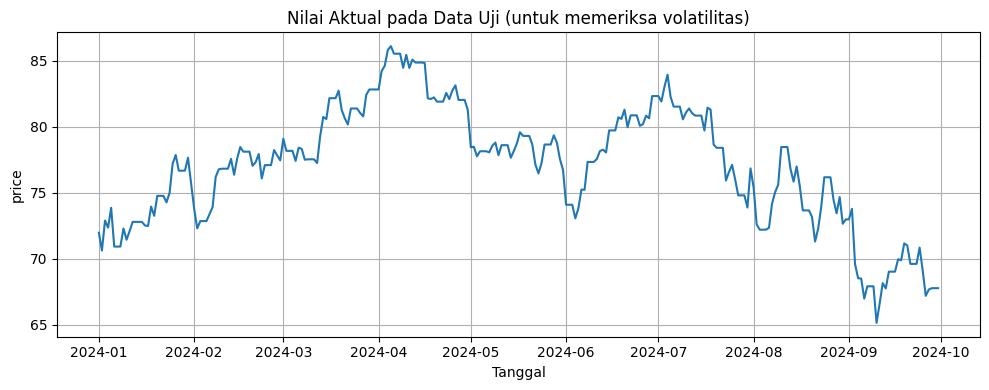


MAE (Manual): 0.4179
RMSE (Manual): 0.5916
MAPE (Manual): 0.5592%


In [ ]:
# Setelah pelatihan dan peramalan XGBoost
print("\nMemeriksa beberapa nilai data uji vs peramalan:")
print("Tanggal | Aktual | Peramalan XGB | Selisih")
print("------- | ------ | ------------- | -------")
for i in range(min(10, len(y_uji_values))): # Cetak 10 baris pertama atau kurang
    tanggal = X_uji.index[i].strftime('%Y-%m-%d')
    aktual = y_uji_values[i]
    prediksi = peramalan_xgb[i]
    selisih = aktual - prediksi
    print(f"{tanggal} | {aktual:.4f} | {prediksi:.4f} | {selisih:.4f}")

# Visualisasi data uji saja
plt.figure(figsize=(10, 4))
plt.plot(data_uji_ml.index, data_uji_ml[target_column], label='Nilai Aktual (Uji)')
plt.title('Nilai Aktual pada Data Uji (untuk memeriksa volatilitas)')
plt.xlabel('Tanggal')
plt.ylabel(target_column)
plt.grid(True)
plt.tight_layout()
plt.show()

# Hitung MAE dan RMSE secara manual untuk memastikan konsistensi
mae_manual = np.mean(np.abs(y_uji_values - peramalan_xgb))
rmse_manual = np.sqrt(np.mean((y_uji_values - peramalan_xgb)**2))
print(f"\nMAE (Manual): {mae_manual:.4f}")
print(f"RMSE (Manual): {rmse_manual:.4f}")

# Hitung MAPE secara manual lagi, pastikan tidak ada pembagian dengan nol
mape_manual_safe = np.mean(np.abs((y_uji_values - peramalan_xgb) / y_uji_values)) * 100
# Jika ada nilai y_uji yang 0 atau mendekati 0, penanganan khusus diperlukan.
# Untuk harga, ini jarang terjadi.
print(f"MAPE (Manual): {mape_manual_safe:.4f}%")

### 4. Melatih Model XGBoost dengan Parameter Terbaik dan Mengevaluasi

Setelah menemukan parameter terbaik dari *tuning*, kita akan melatih ulang model XGBoost menggunakan semua data latih (`X_latih`) dengan parameter terbaik tersebut. Kemudian, kita akan mengevaluasinya secara independen pada data uji (`X_uji`) untuk mendapatkan estimasi kinerja yang tidak bias.

In [ ]:
# Ambil parameter terbaik dari hasil random search
best_params = random_search.best_params_

# Inisialisasi model XGBoost dengan parameter terbaik
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   random_state=42,
                                   n_jobs=-1,
                                   **best_params) # Menggunakan dictionary unpacking untuk parameter terbaik

# Latih model yang sudah di-tune menggunakan seluruh data latih
print("\nMelatih model XGBoost dengan parameter terbaik pada seluruh data latih...")
# Opsional: Anda bisa menggunakan early stopping lagi di sini, tapi pastikan eval_set berbeda
# atau gunakan k-fold validasi dari TimeSeriesSplit untuk mendapatkan best_iteration
# Namun, untuk menyederhanakan setelah tuning, kita latih pada seluruh data latih
model_xgb_tuned.fit(X_latih, y_latih)
print("Pelatihan model XGBoost yang di-tune selesai.")

# Lakukan peramalan pada data uji menggunakan model yang sudah di-tune
print("\nMelakukan peramalan pada data uji menggunakan model XGBoost yang di-tune...")
peramalan_xgb_tuned = model_xgb_tuned.predict(X_uji)
print("Peramalan selesai.")

# Pastikan y_uji adalah array numpy atau Series pandas
y_uji_values = y_uji.values if isinstance(y_uji, (pd.Series, pd.DataFrame)) else y_uji

# Hitung metrik evaluasi untuk model yang sudah di-tune
mae_xgb_tuned = mean_absolute_error(y_uji_values, peramalan_xgb_tuned)
mse_xgb_tuned = mean_squared_error(y_uji_values, peramalan_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mse_xgb_tuned)
mape_xgb_tuned = np.mean(np.abs((y_uji_values - peramalan_xgb_tuned) / y_uji_values)) * 100 # Hitung MAPE

print("\nMetrik Evaluasi Model XGBoost (Tuned) pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_xgb_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_xgb_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_tuned:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_tuned:.4f}%")


Melatih model XGBoost dengan parameter terbaik pada seluruh data latih...
Pelatihan model XGBoost yang di-tune selesai.

Melakukan peramalan pada data uji menggunakan model XGBoost yang di-tune...
Peramalan selesai.

Metrik Evaluasi Model XGBoost (Tuned) pada Data Uji:
Mean Absolute Error (MAE): 0.4481
Mean Squared Error (MSE): 0.3524
Root Mean Squared Error (RMSE): 0.5936
Mean Absolute Percentage Error (MAPE): 0.5936%


### 5. Visualisasi Hasil Peramalan Model XGBoost (Tuned)

Visualisasikan hasil peramalan dari model XGBoost yang sudah di-tune dan bandingkan dengan nilai aktual pada data uji.

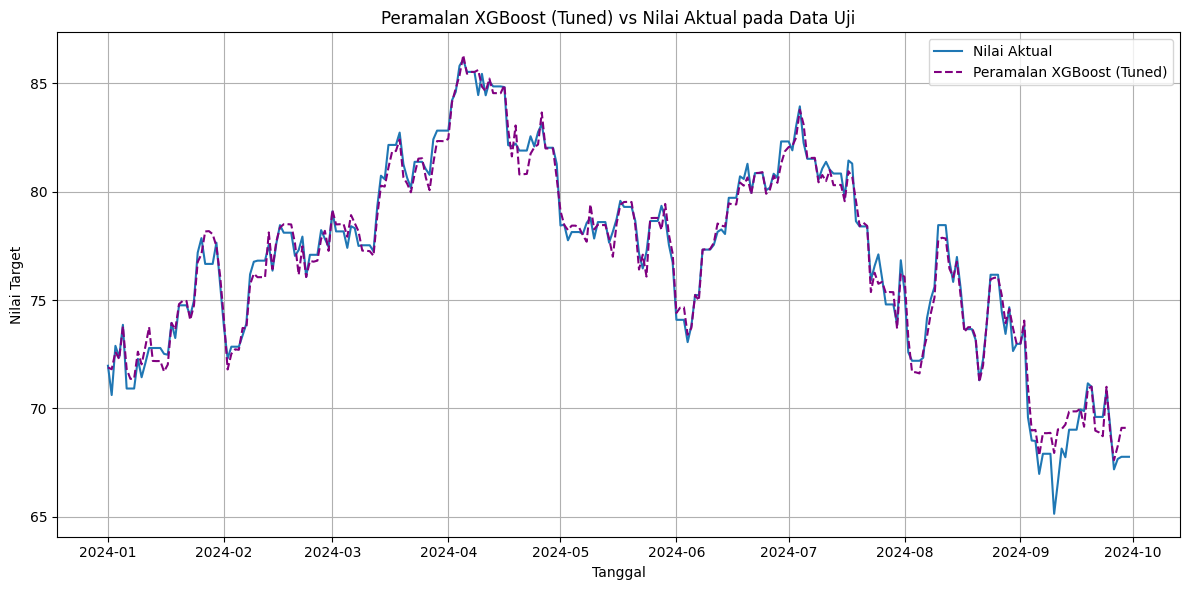

In [ ]:
# Buat DataFrame untuk visualisasi hasil XGBoost yang di-tune
hasil_peramalan_xgb_tuned_df = pd.DataFrame({
    'Aktual': y_uji_values,
    'Peramalan_XGB_Tuned': peramalan_xgb_tuned
}, index=X_uji.index) # Gunakan indeks dari X_uji untuk tanggal

# Visualisasikan hasil peramalan XGBoost (Tuned) vs nilai aktual
plt.figure(figsize=(12, 6))
plt.plot(hasil_peramalan_xgb_tuned_df.index, hasil_peramalan_xgb_tuned_df['Aktual'], label='Nilai Aktual')
plt.plot(hasil_peramalan_xgb_tuned_df.index, hasil_peramalan_xgb_tuned_df['Peramalan_XGB_Tuned'], label='Peramalan XGBoost (Tuned)', color='purple', linestyle='--')
plt.title('Peramalan XGBoost (Tuned) vs Nilai Aktual pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Ringkasan dan Perbandingan Akhir

Dengan selesainya *hyperparameter tuning*, kita sekarang memiliki model XGBoost yang dioptimalkan. Bandingkan metrik evaluasi dari model XGBoost yang di-tune dengan model XGBoost awal (tanpa tuning) dan juga model ARIMA (jika ada).

-   Apakah *tuning* memberikan peningkatan kinerja (metrik error lebih rendah)?
-   Model mana (ARIMA, RF, XGBoost awal, XGBoost tuned) yang memberikan peramalan terbaik berdasarkan metrik pada data uji?

Ini akan membantu dalam menentukan model terbaik untuk peramalan deret waktu ini.

**Langkah Selanjutnya (Potensi Pengembangan):**

-   **Model Ensemble:** Gabungkan peramalan dari beberapa model (misalnya, ARIMA dan XGBoost) untuk potensi peningkatan kinerja.
-   **Deep Learning:** Jelajahi model Deep Learning seperti LSTM atau Transformer untuk peramalan deret waktu, terutama jika ada pola yang sangat kompleks atau data yang sangat besar.
-   **Analisis Residual Lanjutan:** Periksa residual dari model terbaik untuk mengidentifikasi apakah masih ada pola yang belum tertangkap.

## Ensemble Learning: Menggabungkan Kekuatan Model

Setelah mengeksplorasi model deret waktu tradisional (ARIMA/SARIMA) dan model Machine Learning (Random Forest, XGBoost), kita mungkin menemukan bahwa setiap model memiliki kekuatan dan kelemahan tersendiri. Model ARIMA baik dalam menangkap dependensi linier temporal, sementara model berbasis pohon unggul dalam menangkap hubungan non-linier dan interaksi antar fitur.

**Ensemble Learning** adalah teknik di mana kita menggabungkan prediksi dari beberapa model independen (disebut *base models* atau *weak learners*) untuk menghasilkan prediksi akhir yang lebih kuat dan seringkali lebih akurat serta robust daripada prediksi model tunggal. Ide utamanya adalah bahwa kesalahan yang dibuat oleh satu model dapat dikoreksi oleh model lain.

Teknik *ensembling* yang umum meliputi:

1.  **Averaging/Weighted Averaging:** Mengambil rata-rata sederhana atau rata-rata berbobot dari prediksi model individu.
2.  **Bagging:** Melatih model yang sama pada subset data yang berbeda (misalnya, Random Forest).
3.  **Boosting:** Melatih model secara sekuensial untuk memperbaiki kesalahan model sebelumnya (misalnya, XGBoost).
4.  **Stacking:** Melatih model tingkat kedua (disebut *meta-model*) untuk mempelajari cara menggabungkan prediksi dari model-model dasar.

Untuk kasus kita, di mana kita memiliki prediksi dari model ARIMA dan model XGBoost, pendekatan paling sederhana adalah **Averaging** atau **Weighted Averaging**.

Kita akan mendemonstrasikan **Averaging Sederhana**, di mana prediksi akhir adalah rata-rata dari prediksi model ARIMA dan model XGBoost yang sudah di-tune.

Langkah-langkahnya adalah sebagai berikut:

1.  **Mengumpulkan Prediksi dari Model Individu:** Mengambil hasil peramalan dari model ARIMA (pada data uji) dan model XGBoost yang di-tune (pada data uji).
2.  **Menghitung Prediksi Ensemble (Averaging):** Menghitung rata-rata dari kedua prediksi tersebut.
3.  **Mengevaluasi Prediksi Ensemble:** Mengevaluasi kinerja prediksi ensemble pada data uji menggunakan metrik peramalan.
4.  **Visualisasi Hasil Ensemble:** Memvisualisasikan prediksi ensemble dibandingkan dengan nilai aktual dan prediksi model individu.

In [ ]:
import pickle
import requests
import os

# Definisikan path lokal tempat model seharusnya berada
direktori_model_lokal = 'outputs/model/'
file_model_arima = 'arima_crude_oil_model.pkl'
path_model_lokal = os.path.join(direktori_model_lokal, file_model_arima)

# URL raw content file pickle di GitHub
url_model_arima = 'https://raw.githubusercontent.com/zakizulham/proyek-peramalan-global-comodity-price-september-2024/main/outputs/model/arima_crude_oil_model.pkl'

# Periksa apakah file model ada di path lokal
if os.path.exists(path_model_lokal):
    print(f"File model ditemukan di '{path_model_lokal}'. Memuat dari lokal...")
    try:
        # Memuat model dari file pickle lokal
        with open(path_model_lokal, 'rb') as f:
            model_fit1 = pickle.load(f)

        print(f"Model ARIMA berhasil dimuat dari '{path_model_lokal}'.")
        print("\nRingkasan Model yang Dimuat:")
        print(model_fit1.summary())

    except Exception as e:
        print(f"Gagal memuat model dari file lokal '{path_model_lokal}': {e}")

else:
    print(f"File model tidak ditemukan di '{path_model_lokal}'. Mengunduh dari GitHub...")
    # Pastikan direktori lokal ada sebelum menyimpan file
    os.makedirs(direktori_model_lokal, exist_ok=True)

    try:
        response = requests.get(url_model_arima)
        response.raise_for_status()

        # Simpan file yang diunduh secara lokal di Colab
        with open(path_model_lokal, 'wb') as f:
            f.write(response.content)

        print(f"File model berhasil diunduh dan disimpan sebagai '{path_model_lokal}'.")

        # Memuat model dari file pickle yang baru diunduh
        with open(path_model_lokal, 'rb') as f:
            model_fit1 = pickle.load(f)

        print(f"Model ARIMA berhasil dimuat dari '{path_model_lokal}'.")
        print("\nRingkasan Model yang Dimuat:")
        print(model_fit1.summary())

    except requests.exceptions.RequestException as e:
        print(f"Gagal mengunduh file model dari GitHub: {e}")
    except Exception as e:
        print(f"Gagal memuat model dari file yang baru diunduh '{path_model_lokal}': {e}")

File model ditemukan di 'outputs/model/arima_crude_oil_model.pkl'. Memuat dari lokal...
Model ARIMA berhasil dimuat dari 'outputs/model/arima_crude_oil_model.pkl'.

Ringkasan Model yang Dimuat:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  728
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1533.379
Date:                Wed, 11 Jun 2025   AIC                           3074.758
Time:                        13:30:39   BIC                           3093.113
Sample:                    01-03-2022   HQIC                          3081.841
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

In [ ]:
# Import pustaka yang diperlukan (pastikan metrik dan visualisasi sudah diimpor sebelumnya)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Pastikan hasil peramalan dari model-model sebelumnya sudah tersedia:
# - peramalan_arima (dari model ARIMA, pada data uji)
# - peramalan_xgb_tuned (dari model XGBoost yang di-tune, pada data uji)
# - y_uji_values (nilai aktual pada data uji)
# - X_uji.index (indeks tanggal untuk data uji)

# Jika belum ada, pastikan bagian-bagian sebelumnya yang menghasilkan variabel-variabel ini sudah dijalankan.

# Mengumpulkan prediksi
# Pastikan kedua array prediksi memiliki panjang yang sama dan sesuai dengan data uji
# Jika peramalan ARIMA dilakukan secara terpisah, pastikan indeksnya sesuai atau align dengan data uji.
# Untuk demo sederhana averaging, kita asumsikan peramalan_arima dan peramalan_xgb_tuned
# sudah dalam format array/list numpy dengan panjang yang sama dan sesuai urutan data uji.

# Misalnya, jika peramalan_arima adalah pandas Series, ubah ke numpy array jika perlu
# peramalan_arima_array = peramalan_arima.values if isinstance(peramalan_arima, (pd.Series, pd.DataFrame)) else peramalan_arima
# peramalan_xgb_tuned_array = peramalan_xgb_tuned # Diasumsikan sudah numpy array dari langkah sebelumnya

# Untuk memastikan konsistensi, kita bisa membuat DataFrame dari prediksi dan menggabungkannya
# Ini juga memudahkan visualisasi nanti dengan indeks waktu
prediksi_df = pd.DataFrame({
    'Aktual': y_uji_values
}, index=X_uji.index)

# Tambahkan prediksi ARIMA (Pastikan ini sesuai dengan X_uji.index)
# Jika peramalan ARIMA Anda adalah hasil .predict(n_periods=len(X_uji)), Anda perlu memastikan indeksnya sesuai
# Contoh: Jika model_fit1 adalah model ARIMA, dan Anda mendapatkan peramalan sbg Series:
peramalan_arima_series = model_fit1.predict(start=X_uji.index[0], end=X_uji.index[-1])
prediksi_df['Peramalan_ARIMA'] = peramalan_arima_series # Pastikan indeksnya align!

# *Asumsi*: Anda memiliki variabel `peramalan_arima` yang merupakan numpy array atau pandas Series
# yang berisi peramalan model ARIMA untuk periode yang sama dengan `X_uji`.
# Jika tidak, Anda perlu menjalankan kembali peramalan ARIMA untuk data uji.

# Jika Anda mendapatkan peramalan_arima dari model_fit1.predict(n_periods), Anda perlu menyesuaikan indeks:
# peramalan_arima_series = model_fit1.predict(n_periods=len(X_uji)) # Ini menghasilkan Series tanpa indeks waktu
# Untuk align, kita bisa set indeksnya:
# peramalan_arima_series.index = X_uji.index
# prediksi_df['Peramalan_ARIMA'] = peramalan_arima_series

# *Alternatif Sederhana (Jika peramalan_arima sudah numpy array/list sesuai urutan X_uji)*
# Gunakan ini jika Anda yakin peramalan_arima sesuai dengan urutan data uji
# prediksi_df['Peramalan_ARIMA'] = peramalan_arima # Asumsikan ini sudah ada dan benar
prediksi_df['Peramalan_XGB_Tuned'] = peramalan_xgb_tuned

# Hitung prediksi ensemble (rata-rata sederhana)
prediksi_df['Peramalan_Ensemble_Avg'] = (prediksi_df['Peramalan_ARIMA'] + prediksi_df['Peramalan_XGB_Tuned']) / 2

print("Prediksi gabungan dan Ensemble (beberapa baris pertama):")
print(prediksi_df.head())

Prediksi gabungan dan Ensemble (beberapa baris pertama):
            Aktual  Peramalan_ARIMA  Peramalan_XGB_Tuned  \
date                                                       
2024-01-01   71.97        72.047578            71.893051   
2024-01-02   70.62        72.117771            71.808891   
2024-01-03   72.89        72.174602            72.612991   
2024-01-04   72.36        72.220614            72.275276   
2024-01-05   73.86        72.257868            73.790184   

            Peramalan_Ensemble_Avg  
date                                
2024-01-01               71.970315  
2024-01-02               71.963331  
2024-01-03               72.393796  
2024-01-04               72.247945  
2024-01-05               73.024026  


### 3. Mengevaluasi Prediksi Ensemble

Evaluasi kinerja prediksi ensemble menggunakan metrik yang sama.

In [ ]:
# Pastikan y_uji_values tersedia
y_uji_values = prediksi_df['Aktual'].values # Mengambil nilai aktual dari DataFrame prediksi_df

# Ambil prediksi ensemble
peramalan_ensemble_avg = prediksi_df['Peramalan_Ensemble_Avg'].values

# Hitung metrik evaluasi untuk Ensemble (Averaging)
mae_ensemble_avg = mean_absolute_error(y_uji_values, peramalan_ensemble_avg)
mse_ensemble_avg = mean_squared_error(y_uji_values, peramalan_ensemble_avg)
rmse_ensemble_avg = np.sqrt(mse_ensemble_avg)
mape_ensemble_avg = np.mean(np.abs((y_uji_values - peramalan_ensemble_avg) / y_uji_values)) * 100 # Hitung MAPE

print("\nMetrik Evaluasi Model Ensemble (Averaging) pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_ensemble_avg:.4f}")
print(f"Mean Squared Error (MSE): {mse_ensemble_avg:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble_avg:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ensemble_avg:.4f}%")


Metrik Evaluasi Model Ensemble (Averaging) pada Data Uji:
Mean Absolute Error (MAE): 2.8317
Mean Squared Error (MSE): 11.0423
Root Mean Squared Error (RMSE): 3.3230
Mean Absolute Percentage Error (MAPE): 3.5860%


### 4. Visualisasi Hasil Ensemble

Visualisasikan prediksi ensemble bersama dengan nilai aktual dan prediksi model individu untuk perbandingan.

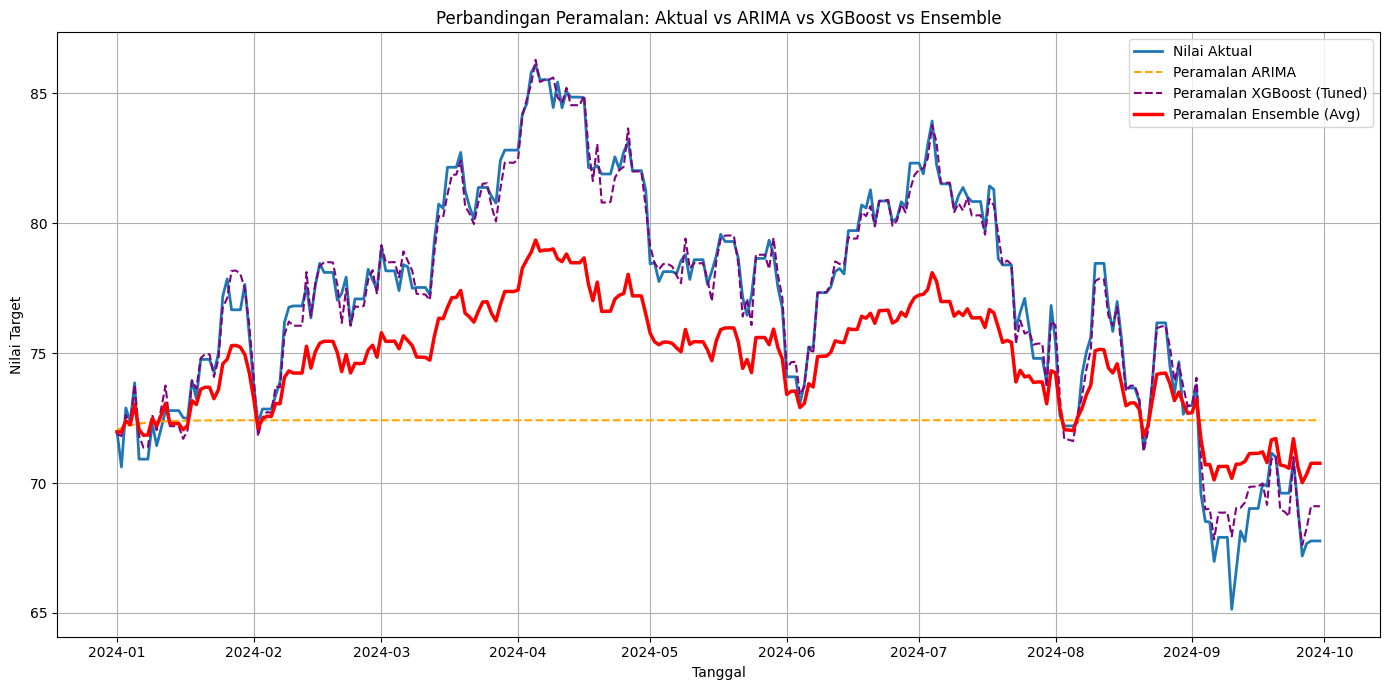

In [ ]:
# Visualisasikan hasil peramalan Aktual vs ARIMA vs XGBoost (Tuned) vs Ensemble
plt.figure(figsize=(14, 7))
plt.plot(prediksi_df.index, prediksi_df['Aktual'], label='Nilai Aktual', linewidth=2)
plt.plot(prediksi_df.index, prediksi_df['Peramalan_ARIMA'], label='Peramalan ARIMA', linestyle='--', color='orange')
plt.plot(prediksi_df.index, prediksi_df['Peramalan_XGB_Tuned'], label='Peramalan XGBoost (Tuned)', linestyle='--', color='purple')
plt.plot(prediksi_df.index, prediksi_df['Peramalan_Ensemble_Avg'], label='Peramalan Ensemble (Avg)', linestyle='-', color='red', linewidth=2.5)
plt.title('Perbandingan Peramalan: Aktual vs ARIMA vs XGBoost vs Ensemble')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analisis Hasil Ensemble

Bandingkan metrik evaluasi dari prediksi ensemble (rata-rata) dengan metrik dari model ARIMA dan XGBoost yang di-tune secara individual. Apakah rata-rata sederhana memberikan peningkatan kinerja?

**Interpretasi:**

-   Ensemble seringkali membantu mengurangi varians prediksi dan membuat hasil lebih robust.
-   Jika satu model memiliki bias pada periode tertentu, model lain mungkin tidak, dan rata-ratanya bisa lebih dekat ke nilai aktual.
-   Jika *averaging* sederhana tidak signifikan lebih baik, pertimbangkan *weighted averaging* di mana bobot diberikan berdasarkan kinerja historis model individu pada data validasi atau bagian awal data uji.

**Langkah Selanjutnya (Potensi Pengembangan Ensemble):**

-   **Weighted Averaging:** Tentukan bobot optimal untuk setiap model (misalnya, bobot berbanding terbalik dengan MSE atau MAPE pada data validasi).
-   **Stacking:** Gunakan model tingkat kedua (misalnya, Linear Regression atau model sederhana lainnya) untuk mempelajari cara terbaik menggabungkan prediksi dari ARIMA dan XGBoost. Model tingkat kedua dilatih pada prediksi model dasar (sebagai fitur) dan nilai aktual (sebagai target) dari data validasi.
-   **Tambah Model Lain:** Sertakan prediksi dari model deret waktu lain (misalnya, SARIMA jika musiman signifikan) atau model ML lain (misalnya, LightGBM) ke dalam ensemble.